In [142]:
import pandas as pd
import numpy as np
import sklearn.model_selection 
import sklearn.tree
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import itertools
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore')

In [143]:
df_athletes_activities = pd.read_csv('C:/Users/USER/Desktop/EstudosDados/Projetos/Corrida/physical_inactivity_prediction/scripts_prediction_model/final/st2_df_athletes_activities.csv', parse_dates=['activity_date'])
df_athletes_activities

,activity_date,athlete_id,total_distance (km),total_time (min),pace (min/km),speed (km/h),weekly_activities_frequency,weekly_active_time,weekly_dist_traveled,days_since_last_activity,...,athlete_max_dist,athlete_avg_dist,athlete_max_time,athlete_avg_time,athlete_max_pace,athlete_avg_pace,athlete_max_speed,athlete_avg_speed,binary_reincidence,accumulated_reincidence
0,2020-07-28,1,13.22,92.0,6.96,8.62,4,314,48,0,...,85.73,24.40,352.0,104.61,9.76,5.21,22.13,12.64,0,0
1,2020-08-04,1,19.22,85.0,4.42,13.57,1,85,19,7,...,85.73,24.40,352.0,104.61,9.76,5.21,22.13,12.64,0,0
2,2020-08-06,1,25.69,128.0,4.98,12.04,2,213,44,2,...,85.73,24.40,352.0,104.61,9.76,5.21,22.13,12.64,0,0
3,2020-08-11,1,25.60,119.0,4.65,12.91,2,247,51,5,...,85.73,24.40,352.0,104.61,9.76,5.21,22.13,12.64,0,0
4,2020-08-13,1,25.31,131.0,5.18,11.59,2,250,50,2,...,85.73,24.40,352.0,104.61,9.76,5.21,22.13,12.64,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,2024-06-16,7,10.06,45.0,4.47,13.26,3,116,22,3,...,13.24,8.42,70.0,45.14,9.23,5.43,13.77,11.12,0,0
855,2024-06-18,7,5.20,33.0,6.35,9.27,3,108,20,2,...,13.24,8.42,70.0,45.14,9.23,5.43,13.77,11.12,0,0
856,2024-06-21,7,12.10,62.0,5.12,11.71,3,140,27,3,...,13.24,8.42,70.0,45.14,9.23,5.43,13.77,11.12,0,0
857,2024-06-26,7,4.08,22.0,5.39,11.13,2,84,16,5,...,13.24,8.42,70.0,45.14,9.23,5.43,13.77,11.12,0,0


<Axes: ylabel='count'>

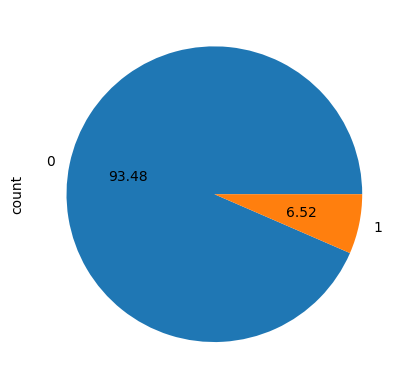

In [144]:
df_athletes_activities['will_churn'].value_counts().plot.pie(autopct = '%.2f')

#### Tratamento de variáveis multicolineares

In [145]:
# Matriz de correlação entre as features, excluindo a data, id do atleta e o target
corr = df_athletes_activities.loc[:, ~df_athletes_activities.columns.isin(['activity_date', 'athlete_id', 'will_churn'])].corr()

# Transformar a matriz de correlação em um DataFrame (formatado de maneira que seja fácil visualizar pares de features)
df_corr = pd.melt(corr, ignore_index=False, var_name='feature2', value_name='correlation')

# Resetar o índice para que 'feature1' seja uma coluna em vez de índice e renomear a coluna de índice para 'feature1'
df_corr = df_corr.reset_index().rename(columns={'index': 'feature1'})

# Remover linhas onde 'feature1' e 'feature2' são iguais (ou seja, a correlação de uma feature com ela mesma)
df_corr.drop(df_corr[(df_corr['feature1'] == df_corr['feature2'])].index, axis=0, inplace=True)

# Remover duplicatas na coluna de correlação, mantendo apenas a primeira ocorrência
df_corr.drop_duplicates(subset='correlation', inplace=True)

# Resetar o índice mais uma vez após remover duplicatas
df_corr.reset_index(drop=True, inplace=True)

df_corr

,feature1,feature2,correlation
0,total_time (min),total_distance (km),0.822640
1,pace (min/km),total_distance (km),-0.135674
2,speed (km/h),total_distance (km),0.622615
3,weekly_activities_frequency,total_distance (km),0.032868
4,weekly_active_time,total_distance (km),0.457516
...,...,...,...
148,binary_reincidence,athlete_max_speed,0.009813
149,accumulated_reincidence,athlete_max_speed,-0.249741
150,binary_reincidence,athlete_avg_speed,0.147276
151,accumulated_reincidence,athlete_avg_speed,0.054220


In [146]:
# Cria um DataFrame vazio para armazenar as médias das correlações absolutas
df_corr_abs_mean = pd.DataFrame()
# Define os índices do DataFrame como as colunas do DataFrame de correlações
df_corr_abs_mean.index = corr.columns

# Itera sobre cada índice (feature) no DataFrame df_corr_abs_mean
for index in df_corr_abs_mean.index:
    # Calcula a média das correlações absolutas para a feature atual
    feature_corr_abs_mean = np.abs(df_corr.loc[(df_corr['feature1'] == index) | (df_corr['feature2'] == index), 'correlation']).mean()
    # Armazena a média calculada no DataFrame df_corr_abs_mean
    df_corr_abs_mean.loc[index, 'correlation'] = feature_corr_abs_mean

# Exibe o DataFrame com as médias das correlações absolutas
df_corr_abs_mean

,correlation
total_distance (km),0.362647
total_time (min),0.303123
pace (min/km),0.114994
speed (km/h),0.249706
weekly_activities_frequency,0.186322
weekly_active_time,0.337897
weekly_dist_traveled,0.412225
days_since_last_activity,0.067566
athlete_max_dist,0.413946
athlete_avg_dist,0.401206


In [147]:
# Selecionando apenas correlações com valor acima de -0.7 ou 0.7 (Forte correlação)
df_strong_corr = df_corr[(np.abs(df_corr['correlation']) > 0.8)]
df_strong_corr

,feature1,feature2,correlation
0,total_time (min),total_distance (km),0.822640
75,weekly_dist_traveled,weekly_active_time,0.814891
108,athlete_avg_dist,athlete_max_dist,0.931655
109,athlete_max_time,athlete_max_dist,0.965024
110,athlete_avg_time,athlete_max_dist,0.902143
113,athlete_max_speed,athlete_max_dist,0.843956
117,athlete_max_time,athlete_avg_dist,0.816118
118,athlete_avg_time,athlete_avg_dist,0.843183
121,athlete_max_speed,athlete_avg_dist,0.864654
125,athlete_avg_time,athlete_max_time,0.828817


In [148]:
# Cria um conjunto vazio para armazenar features a serem removidas
features_to_remove = set()

# Itera sobre cada linha do DataFrame df_strong_corr
for i, row in df_strong_corr.iterrows():
    # Obtém o nome da primeira feature
    feature1 = row['feature1']
    # Obtém o nome da segunda feature
    feature2 = row['feature2']

    # Compara as correlações das duas features
    if df_corr_abs_mean.loc[feature1, 'correlation'] > df_corr_abs_mean.loc[feature2, 'correlation']:
        # Adiciona feature1 ao conjunto se sua correlação for maior
        features_to_remove.add(feature1)
        
    elif df_corr_abs_mean.loc[feature1, 'correlation'] < df_corr_abs_mean.loc[feature2, 'correlation']:
        # Adiciona feature2 ao conjunto se sua correlação for maior
        features_to_remove.add(feature2)
        
        
# Converte o conjunto para uma lista
features_to_remove = list(features_to_remove)

# Exibe a lista de features a serem removidas
print(features_to_remove)

# Remove as features multicolineares selecionadas
df_athletes_activities.drop(features_to_remove, axis = 1, inplace= True)

['athlete_max_dist', 'athlete_max_speed', 'athlete_avg_dist', 'total_distance (km)', 'athlete_max_time', 'weekly_dist_traveled']


In [149]:
def metrics(model, feature, undersampling_n, y_pred_train, y_pred_test, y_train, y_test):
    accuracy_train = sklearn.metrics.accuracy_score(y_train, y_pred_train)
    accuracy_test = sklearn.metrics.accuracy_score(y_test, y_pred_test)

    precision_train = sklearn.metrics.precision_score(y_train, y_pred_train)
    precision_test = sklearn.metrics.precision_score(y_test, y_pred_test)

    recall_train = sklearn.metrics.recall_score(y_train, y_pred_train)
    recall_test = sklearn.metrics.recall_score(y_test, y_pred_test)

    f1_train = sklearn.metrics.f1_score(y_train, y_pred_train)
    f1_test = sklearn.metrics.f1_score(y_test, y_pred_test)

    roc_auc_train = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
    roc_auc_test = sklearn.metrics.roc_auc_score(y_test, y_pred_test)

    return {
            'Algorithm': str(model),
            'Undersampling': str(undersampling_n),
            "Features": str(feature),
            'accuracy_train': round(accuracy_train,2), 
            'accuracy_test': round(accuracy_test,2), 
            'precision_train': round(precision_train,2), 
            'precision_test': round(precision_test, 2), 
            'recall_train': round(recall_train,2), 
            'recall_test': round(recall_test,2), 
            'f1_train': round(f1_train,2), 
            'f1_test': round(f1_test,2), 
            'roc_auc_train': round(roc_auc_train,2), 
            'roc_auc_test': round(roc_auc_test, 2)
            }

In [150]:
def churn_classification(df, model, undersampling_n, features): #função com Undersampling

    X = df[features]
    y = df_athletes_activities['will_churn']

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size= 0.2, random_state= 123, stratify=y)    

    # Undersampling das linhas com False no X e y do conjunto de treino, de acordo com as porcentagens 70:30, 60:40, 50:50
    y_train.drop((y_train[y_train==0].sample(len(y_train[y_train==0]) - int((len(y_train[y_train == 1]) * undersampling_n)/(1 - undersampling_n)), random_state=0)).index, inplace = True)
    X_train = X_train.loc[y_train.index]

    # Treinamento do modelo
    model.fit(X_train, y_train)

    # Predição pro treino
    y_pred_train = model.predict(X_train)

    # Predição pro teste
    y_pred_test = model.predict(X_test)

    # Métricas avaliativas comparando o conjunto de teste e o conjunto previsto a partir do treinamento do modelo + atributos utilizados
    result = metrics(model, features, undersampling_n, y_pred_train, y_pred_test, y_train, y_test)

    return result

In [152]:
# Código com GridSearch

'''
models = {
    'Decision Tree': {
        'model': sklearn.tree.DecisionTreeClassifier(random_state=42),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': sklearn.ensemble.RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

X = df_athletes_activities.loc[:, ~df_athletes_activities.columns.isin(['activity_date', 'athlete_id', 'will_churn'])]
y = df_athletes_activities['will_churn']

results = []

for undersampling_n in [0.5, 0.6, 0.7]:
    print(undersampling_n)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size= 0.2, random_state= 123, stratify=y)

    y_train.drop((y_train[y_train==0].sample(len(y_train[y_train==0]) - int((len(y_train[y_train == 1]) * undersampling_n)/(1 - undersampling_n)), random_state=0)).index, inplace = True)
    X_train = X_train.loc[y_train.index]

    for model_name, model_info in models.items():
        print(f"Treinando e otimizando: {model_name}")
        grid_search = sklearn.model_selection.GridSearchCV(model_info['model'], model_info['params'], cv=3, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        print(grid_search.best_params_)
        print(grid_search.best_score_)

        # Treinamento do modelo 
        model = model_info['model'].set_params(**grid_search.best_params_)
        model.fit(X_train, y_train)

        # Predição pro treino
        y_pred_train = model.predict(X_train)

        # Predição pro teste
        y_pred_test = model.predict(X_test)

        # Métricas avaliativas comparando o conjunto de teste e o conjunto previsto a partir do treinamento do modelo + atributos utilizados
        results.append(metrics(model, undersampling_n, y_pred_train, y_pred_test, y_train, y_test))

        #print(f"Melhores parâmetros para {model_name}: {grid_search.best_params_}")
        #print(f"Melhor score para {model_name}: {grid_search.best_score_}")
'''

'\nmodels = {\n    \'Decision Tree\': {\n        \'model\': sklearn.tree.DecisionTreeClassifier(random_state=42),\n        \'params\': {\n            \'criterion\': [\'gini\', \'entropy\'],\n            \'max_depth\': [None, 10, 20, 30],\n            \'min_samples_split\': [2, 5, 10],\n            \'min_samples_leaf\': [1, 2, 4]\n        }\n    },\n    \'Random Forest\': {\n        \'model\': sklearn.ensemble.RandomForestClassifier(random_state=42),\n        \'params\': {\n            \'n_estimators\': [50, 100, 200],\n            \'criterion\': [\'gini\', \'entropy\'],\n            \'max_depth\': [None, 10, 20, 30],\n            \'min_samples_split\': [2, 5, 10],\n            \'min_samples_leaf\': [1, 2, 4]\n        }\n    }\n}\n\nX = df_athletes_activities.loc[:, ~df_athletes_activities.columns.isin([\'activity_date\', \'athlete_id\', \'will_churn\'])]\ny = df_athletes_activities[\'will_churn\']\n\nresults = []\n\nfor undersampling_n in [0.5, 0.6, 0.7]:\n    print(undersampling_n)\n\

In [153]:
df_athletes_activities.loc[:, ~df_athletes_activities.columns.isin(['activity_date', 'athlete_id', 'will_churn'])].columns

Index(['total_time (min)', 'pace (min/km)', 'speed (km/h)',
       'weekly_activities_frequency', 'weekly_active_time',
       'days_since_last_activity', 'athlete_avg_time', 'athlete_max_pace',
       'athlete_avg_pace', 'athlete_avg_speed', 'binary_reincidence',
       'accumulated_reincidence'],
      dtype='object')

In [154]:
seed = 123

undersampling_n = [0.9, 0.8, 0.7] 
models = [sklearn.tree.DecisionTreeClassifier(random_state= seed), sklearn.ensemble.RandomForestClassifier(random_state= seed)]
features = df_athletes_activities.loc[:, ~df_athletes_activities.columns.isin(['activity_date', 'athlete_id', 'will_churn'])].columns

# Função para gerar todas as combinações possíveis
all_features_comb = []

for r in range(1, len(features) + 1):
    combinations_r = list(itertools.combinations(features, r))
    all_features_comb.extend(combinations_r)

all_features_comb_lists = [list(comb) for comb in all_features_comb]

products = [dict(zip(('model', 'undersampling', 'features'), (i,j,k))) for i,j,k in itertools.product(models, undersampling_n, all_features_comb_lists)]

In [155]:
len(products)

24570

In [156]:
results  = [churn_classification(df_athletes_activities, product['model'], product['undersampling'], product['features']) for product in products]

In [157]:
df_results = pd.DataFrame(results)
df_results.sort_values('f1_test', ascending=False, inplace=True)
df_results

,Algorithm,Undersampling,Features,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,roc_auc_train,roc_auc_test
16521,RandomForestClassifier(random_state=123),0.8,"['pace (min/km)', 'speed (km/h)', 'accumulated...",1.00,0.45,0.98,0.82,0.99,0.58,0.99,0.87
1134,DecisionTreeClassifier(random_state=123),0.9,"['pace (min/km)', 'speed (km/h)', 'weekly_acti...",1.00,0.47,0.93,0.73,0.97,0.57,0.97,0.84
2073,DecisionTreeClassifier(random_state=123),0.9,"['pace (min/km)', 'speed (km/h)', 'weekly_acti...",1.00,0.43,0.93,0.82,0.97,0.56,0.97,0.87
1131,DecisionTreeClassifier(random_state=123),0.9,"['pace (min/km)', 'speed (km/h)', 'weekly_acti...",1.00,0.41,0.93,0.82,0.97,0.55,0.97,0.87
464,DecisionTreeClassifier(random_state=123),0.9,"['pace (min/km)', 'speed (km/h)', 'weekly_acti...",1.00,0.44,0.93,0.73,0.97,0.55,0.97,0.83
...,...,...,...,...,...,...,...,...,...,...,...
15177,RandomForestClassifier(random_state=123),0.9,"['total_time (min)', 'weekly_activities_freque...",1.00,0.00,0.98,0.00,0.99,0.00,0.99,0.49
15176,RandomForestClassifier(random_state=123),0.9,"['total_time (min)', 'weekly_activities_freque...",1.00,0.00,0.98,0.00,0.99,0.00,0.99,0.49
15175,RandomForestClassifier(random_state=123),0.9,"['total_time (min)', 'weekly_activities_freque...",1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.49
15174,RandomForestClassifier(random_state=123),0.9,"['total_time (min)', 'weekly_activities_freque...",1.00,0.00,0.98,0.00,0.99,0.00,0.99,0.49


In [158]:
df_results.to_csv('C:/Users/USER/Desktop/EstudosDados/Projetos/Corrida/physical_inactivity_prediction/scripts_prediction_model/final/results.csv', index = False)